In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("plots", exist_ok=True)

# Initializing Mess3Process class

In [2]:
class Mess3Process:
    def __init__(self, x=0.05, alpha=0.85, device='cuda'):
        self.x = x
        self.alpha = alpha
        self.device = device
        self.T = self.get_transition_matrix()
        # For a generic process, replace the prior with the stationary distribution
        self.prior = torch.ones(3, device = device) / 3
        

    def get_transition_matrix(self):
        x = self.x
        alpha = self.alpha
        T = torch.zeros((3, 3, 3))  # Shape: [source, target, token]
        for source in range(3):  # iterating over source hidden states
            for target in range(3):  # iterating over target hidden states
                for token in range(3):  # iterating over tokens
                    # p(source->target)
                    p_source_target = 1 - 2 * x if source == target else x
                    # p(token | target)
                    p_token = alpha if token == target else (1 - alpha) / 2
                    T[source, target, token] = p_source_target * p_token
        return T.to(self.device)

    def find_next_state(self, current_states):
        """
        current_states: Tensor of shape (B,) where each entry is an integer state (0, 1, or 2)
        Returns:
            next_states: Tensor of shape (B,)
            tokens: Tensor of shape (B,)
        """
        B = current_states.shape[0]
        # For each state in the batch, select the [target x token] matrix.
        probs = self.T[current_states]  # shape: (B, 3, 3)
        probs = probs.view(B, -1)       # flatten each [3, 3] matrix to a vector of size 9 per batch element
        # Sample an index for each element in the batch.
        idx = torch.multinomial(probs, num_samples=1).squeeze(1)  # shape: (B,)
        next_states = idx // 3
        tokens = idx % 3
        return next_states, tokens

    def generate_sequences(self, length=10, batch_size=32):
        """
        Generates a batch of sequences.
        Returns:
            sequences: Tensor of shape (B, L) containing tokens.
            states_seq: Tensor of shape (B, L) containing the next hidden states.
        """
        sequences = []   # to collect tokens from each time step (each: shape (B,))
        states_seq = []  # to collect next states from each time step (each: shape (B,))
        # Initialize a batch of starting states.
        current_states = torch.randint(0, 3, (batch_size,))
        for _ in range(length):
            next_states, tokens = self.find_next_state(current_states)
            sequences.append(tokens)      # tokens: shape (B,)
            states_seq.append(next_states)
            current_states = next_states  # update states for the next step
        # Stack along the time dimension to yield tensors of shape (B, L)
        sequences = torch.stack(sequences, dim=1)
        states_seq = torch.stack(states_seq, dim=1)
        return sequences, states_seq

    def update_belief_state(self, current_belief, tokens):
        """
        current_belief: Tensor of shape (B, 3), representing the belief distribution for each sample.
        tokens: Tensor of shape (B,), each an integer token.
        
        For each sample i, the update is:
            next_belief[i] = current_belief[i] @ T[:, :, tokens[i]]
        Uses vectorized operations with torch.bmm.
        """
        # Rearrange T so that tokens come first: shape (3, 3, 3) -> (token, source, target)
        T_batch = self.T.permute(2, 0, 1)[tokens]  # shape: (B, 3, 3)
        next_belief = torch.bmm(current_belief.unsqueeze(1), T_batch).squeeze(1)  # shape: (B, 3)
        # Normalize each belief vector
        next_belief = next_belief / next_belief.sum(dim=1, keepdim=True)
        return next_belief

    def find_belief_states(self, sequences):
        """
        sequences: Tensor of shape (B, L) where each row is a sequence of tokens.
        Returns: belief_states, a tensor of shape (B, L+1, 3), where the initial belief is the prior.
        """
        B, L = sequences.shape
        current_belief = self.prior.unsqueeze(0).expand(B, -1)  # shape: (B, 3)
        belief_states = [current_belief]
        for t in range(L):
            current_belief = self.update_belief_state(current_belief, sequences[:, t])
            belief_states.append(current_belief)
        # Stack along the time dimension: (B, L+1, 3)
        belief_states = torch.stack(belief_states, dim=1)
        return belief_states

    def find_belief_loss(self, sequences, include_start = True):
        """
        sequences: Tensor of shape (B, L) containing tokens.
        Computes the belief loss averaged over both batch and time dimensions.
        The prediction for the next state is obtained by multiplying the current belief state
        with the transition matrix summed over the target dimension.
        """
        B, L = sequences.shape
        belief_states = self.find_belief_states(sequences)  # shape: (B, L+1, 3)
        # Sum T over the target dimension: resulting shape (3, 3)
        transition_matrix = self.T.sum(dim=-2)  
        # For each batch sample and time step, compute the predicted next state distribution:
        predicted = torch.bmm(belief_states[:, :-1, :], transition_matrix.expand(B, -1, -1))  # shape: (B, L, 3)
        # print(predicted)
        # Gather the probability of the actual observed token at each time step.
        token_probs = predicted.gather(dim=2, index=sequences.unsqueeze(-1)).squeeze(-1)  # shape: (B, L)
        empirical_loss = -torch.log(token_probs)
        start_index = 1 - int(include_start)
        return empirical_loss[:, start_index:]

# Getting faimiliar with Mess3

## Updating belief states

In [3]:
mess3 = Mess3Process()
tokens, states = mess3.generate_sequences(batch_size = 1, length = 20)
belief_states = mess3.find_belief_states(tokens)[0]
df = pd.DataFrame()

df['States'] = states[0].cpu()
df['Emissions'] = tokens[0].cpu()
df.style.hide(axis='index')
display(df.T)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
States      1   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0   0   
Emissions   1   1   1   1   0   1   1   1   1   1   1   1   0   2   0   0   0   

           17  18  19  
States      0   2   2  
Emissions   0   2   2

In [4]:
data = []
for t, emission in enumerate(tokens[0]):
    # Get the belief state at time t and the updated belief state at time t+1.
    curr_belief = np.round(belief_states[t].tolist(), 2)
    updated_belief = np.round(belief_states[t+1].tolist(), 2)
    data.append({
        ("Current Belief state", r"$\eta(A)$"): curr_belief[0],
        ("Current Belief state", r"$\eta(B)$"): curr_belief[1],
        ("Current Belief state", r"$\eta(C)$"): curr_belief[2],
        ("Emission", ""): int(emission.item()),
        ("Updated Belief state", r"$\eta^\prime(A)$"): updated_belief[0],
        ("Updated Belief state", r"$\eta^\prime(B)$"): updated_belief[1],
        ("Updated Belief state", r"$\eta^\prime(C)$"): updated_belief[2]
    })

# Create DataFrame with MultiIndex columns
df = pd.DataFrame(data)

# Convert keys to MultiIndex for proper display
df.columns = pd.MultiIndex.from_tuples(df.columns)

# Display the DataFrame without showing the index column
# display(df.style.hide(axis='index'))

# Define a formatting dictionary to apply different formats for each column.
format_dict = {
    ("Current Belief state", r"$\eta(A)$"): "{:.2f}",
    ("Current Belief state", r"$\eta(B)$"): "{:.2f}",
    ("Current Belief state", r"$\eta(C)$"): "{:.2f}",
    ("Emission", ""): "{}",
    ("Updated Belief state", r"$\eta^\prime(A)$"): "{:.2f}",
    ("Updated Belief state", r"$\eta^\prime(B)$"): "{:.2f}",
    ("Updated Belief state", r"$\eta^\prime(C)$"): "{:.2f}"
}

styled_df = df.style.hide(axis='index').format(format_dict)

# Display the styled DataFrame
display(styled_df)

## Plotting belief states

In [5]:
mess3 = Mess3Process()
tokens, states = mess3.generate_sequences(batch_size = 400, length = 1000)
belief_states = mess3.find_belief_states(tokens)

# Convert belief states (which are PyTorch tensors or lists) to NumPy arrays
belief_states_np = np.array([bs.cpu().numpy()[1:] if torch.is_tensor(bs) else np.array(bs)
                             for bs in belief_states]).reshape(-1, 3)

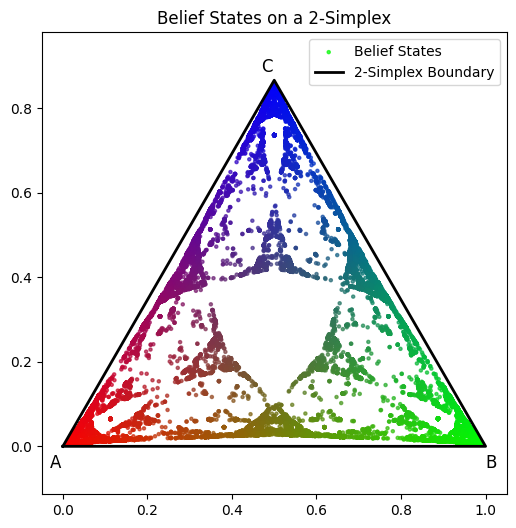

In [6]:
# Convert each belief state from barycentric (p_A, p_B, p_C) to Cartesian (x, y)
# using: x = p_B + 0.5 * p_C,  y = (sqrt(3)/2) * p_C.
xs = belief_states_np[:, 1] + 0.5 * belief_states_np[:, 2]
ys = (np.sqrt(3)/2) * belief_states_np[:, 2]

# Create a new plot
plt.figure(figsize=(6,6))

# Plot the trajectory of belief states
# plt.plot(xs, ys, 'x', color='blue', alpha = 0.7, label='Belief States')
plt.scatter(xs[1:], ys[1:], c=belief_states_np[1:], marker='.', s=20, alpha=0.7, label='Belief States')

# Define the vertices of the 2-simplex
A = (0, 0)  # Vertex for State A
B = (1, 0)  # Vertex for State B
C = (0.5, np.sqrt(3)/2)  # Vertex for State C

# Create a triangle by connecting the vertices
triangle = np.array([A, B, C, A])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-', lw=2, label='2-Simplex Boundary')

# Annotate the vertices
plt.text(A[0] - 0.03, A[1] - 0.05, 'A', fontsize=12)
plt.text(B[0] + 0.0, B[1] - 0.05, 'B', fontsize=12)
plt.text(C[0] - 0.03, C[1] + 0.02, 'C', fontsize=12)

# Set labels and title
# plt.xlabel('x')
# plt.ylabel('y')
plt.title('Belief States on a 2-Simplex')
plt.legend()
plt.axis('equal')
plt.savefig("plots/belief_states.png", dpi=300, bbox_inches="tight")
# Display the plot
plt.show()

## Calculating best loss

In [7]:
mess3 = Mess3Process()
BATCH = 10000
tokens, states = mess3.generate_sequences(10, BATCH)
losses = mess3.find_belief_loss(tokens).mean(axis = -1)

In [8]:
tokens = torch.tensor([[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]]).to('cuda')
print(f"Loss = {mess3.find_belief_loss(tokens).mean().item():.2f}")
belief_states = mess3.find_belief_states(tokens).cpu().numpy()

Loss = 0.86


In [9]:
df = pd.DataFrame()
ntp = belief_states[0, np.arange(10), :]@ mess3.T.sum(-2).cpu().numpy()
df['Current Belief State'] = list(np.round(belief_states[0, :-1], 2))
df['Emissions'] = tokens[0, :10].cpu()
df[r'$- \log P(x | \eta) $'] = np.round(-np.log(ntp[np.arange(10), tokens[0].cpu()]), 2)
styled_df = df.style.hide(axis='index').format("{:.2f}")
df

Current Belief State  Emissions  $- \log P(x | \eta) $
0   [0.33, 0.33, 0.33]          1                   1.10
1   [0.08, 0.85, 0.08]          1                   0.39
2   [0.01, 0.97, 0.01]          0                   2.10
3   [0.42, 0.54, 0.04]          1                   0.76
4   [0.07, 0.92, 0.01]          1                   0.33
5   [0.01, 0.98, 0.01]          1                   0.27
6   [0.01, 0.99, 0.01]          1                   0.27
7   [0.01, 0.99, 0.01]          1                   0.27
8   [0.01, 0.99, 0.01]          0                   2.14
9    [0.4, 0.57, 0.03]          0                   0.98

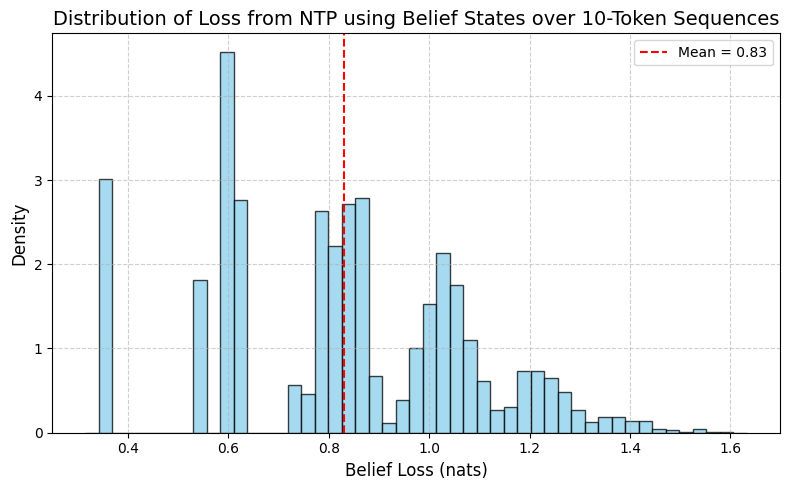

In [10]:
plt.figure(figsize=(8, 5))
losses = losses.cpu()
plt.hist(
    losses,
    bins=np.linspace(losses.min() - 0.05, losses.max() + 0.05, 50),
    density=True,
    alpha=0.75,
    color='skyblue',
    edgecolor='black'
)

plt.title("Distribution of Loss from NTP using Belief States over 10-Token Sequences", fontsize=14)
plt.xlabel("Belief Loss (nats)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: show mean as vertical line
plt.axvline(losses.mean(), color='red', linestyle='--', label=f"Mean = {losses.mean():.2f}")
plt.legend()

plt.tight_layout()
plt.savefig("plots/loss_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

# Training a transformer model

## Plot utils (Using plotting style from epsilon-transformers)

In [11]:
from jaxtyping import Float
from typing import Literal, cast
from matplotlib.figure import Figure
import datashader as ds
import datashader.transfer_functions as tf  # type: ignore
from PIL import Image
from sklearn.linear_model import LinearRegression  # type: ignore

def _project_to_simplex(points: Float[np.ndarray, "num_points num_states"]):
    """Project points onto the 2-simplex (equilateral triangle in 2D)."""
    x = points[:, 1] + 0.5 * points[:, 2]
    y = (np.sqrt(3) / 2) * points[:, 2]
    return x, y


# Combine aggregated channels into RGB images
def _combine_channels_to_rgb(agg_r, agg_g, agg_b, px: int):
    img_r = tf.shade(agg_r, cmap=["black", "red"], how="linear")
    img_g = tf.shade(agg_g, cmap=["black", "green"], how="linear")
    img_b = tf.shade(agg_b, cmap=["black", "blue"], how="linear")

    img_r = tf.spread(img_r, px=px, shape="circle")
    img_g = tf.spread(img_g, px=px, shape="circle")
    img_b = tf.spread(img_b, px=px, shape="circle")

    # Combine using numpy
    r_array = np.array(img_r.to_pil()).astype(np.float64)
    g_array = np.array(img_g.to_pil()).astype(np.float64)
    b_array = np.array(img_b.to_pil()).astype(np.float64)

    # Stack arrays into an RGB image (ignoring alpha channel for simplicity)
    rgb_image = np.stack(
        [r_array[:, :, 0], g_array[:, :, 1], b_array[:, :, 2]], axis=-1
    )

    return Image.fromarray(np.uint8(rgb_image))


def plot_ground_truth_and_evaluated_2d_simplex(
    ground_truth_tensor: Float[np.ndarray, "num_points num_states"],
    predicted_beliefs: Float[np.ndarray, "num_points num_states"],
    plot_triangles: bool,
    facecolor: Literal["black", "white"],
    px: int,
) -> Figure:
    # Projection and DataFrame preparation
    bs_x, bs_y = _project_to_simplex(np.array(ground_truth_tensor))
    ground_truth_data_frame = pd.DataFrame(
        {
            "x": bs_x,
            "y": bs_y,
            "r": ground_truth_tensor[:, 0],
            "g": ground_truth_tensor[:, 1],
            "b": ground_truth_tensor[:, 2],
        }
    )

    pb_x, pb_y = _project_to_simplex(np.array(predicted_beliefs))
    predicted_belief_vector_data_frame = pd.DataFrame(
        {
            "x": pb_x,
            "y": pb_y,
            "r": predicted_beliefs[:, 0],
            "g": predicted_beliefs[:, 1],
            "b": predicted_beliefs[:, 2],
        }
    )

    # Create canvas
    canvas = ds.Canvas(
        plot_width=1000,
        plot_height=1000,
        x_range=(-0.1, 1.1),
        y_range=(-0.1, np.sqrt(3) / 2 + 0.1),
    )

    # Aggregate each RGB channel separately for ground truth and predicted beliefs
    colours = ["r", "g", "b"]
    ground_truth_aggregated = {
        color: canvas.points(ground_truth_data_frame, "x", "y", ds.mean(color))
        for color in colours
    }
    predited_belief_vector_aggregated = {
        color: canvas.points(
            predicted_belief_vector_data_frame, "x", "y", ds.mean(color)
        )
        for color in colours
    }

    img_gt = _combine_channels_to_rgb(
        ground_truth_aggregated["r"],
        ground_truth_aggregated["g"],
        ground_truth_aggregated["b"],
        px=px,
    )
    img_pb = _combine_channels_to_rgb(
        predited_belief_vector_aggregated["r"],
        predited_belief_vector_aggregated["g"],
        predited_belief_vector_aggregated["b"],
        px=px,
    )

    # Visualization with Matplotlib
    fig, axs = cast(
        tuple[plt.Figure, list[plt.Axes]],
        plt.subplots(
            1, 2, figsize=(10, 5), sharex=True, sharey=True, facecolor=facecolor
        ),
    )
    for ax in axs:
        ax.tick_params(axis="x", colors=facecolor)
        ax.tick_params(axis="y", colors=facecolor)
        ax.xaxis.label.set_color(facecolor)
        ax.yaxis.label.set_color(facecolor)
        ax.title.set_color(facecolor)
    axs[0].imshow(img_gt)
    axs[1].imshow(img_pb)

    axs[0].axis("off")
    axs[1].axis("off")
    title_y_position = (
        -0.1
    )  # Adjust this value to move the title up or down relative to the axes
    fig.text(
        0.5,
        title_y_position,
        "Ground Truth",
        ha="center",
        va="top",
        transform=axs[0].transAxes,
        color="white",
        fontsize=15,
    )  # Changed 'black' to 'white'
    fig.text(
        0.5,
        title_y_position,
        "Residual Stream",
        ha="center",
        va="top",
        transform=axs[1].transAxes,
        color="white",
        fontsize=15,
    )  # Changed 'black' to 'white'

    if plot_triangles:
        for ax in axs:
            ax.plot(
                [0, 0.5, 1, 0], [0, np.sqrt(3) / 2, 0, 0], "white", lw=2
            )  # Changed 'black' to 'white'

    return fig
    

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [12]:
@torch.no_grad()
def plot_model_activations(model, SEQ_LEN, BATCH_SIZE_PLOT = 4000, n_jobs = 1):
    mess3 = Mess3Process()
    input_seqs, _ = mess3.generate_sequences(SEQ_LEN, BATCH_SIZE_PLOT)
    belief_states = mess3.find_belief_states(input_seqs)[:, 1:]
    logits, cache = model.run_with_cache(input_seqs)
    final_activations = cache["ln_final.hook_normalized"].detach().cpu().numpy()
    activations_reshaped = final_activations.reshape(-1, model.cfg.d_model)
    ground_truth_belief_states_reshaped = belief_states.reshape(-1,3).cpu().numpy()
    reg = LinearRegression(n_jobs = n_jobs).fit(
        activations_reshaped, ground_truth_belief_states_reshaped
    )
    predicted_beliefs = reg.predict(activations_reshaped)
    fig = plot_ground_truth_and_evaluated_2d_simplex(
        ground_truth_tensor=ground_truth_belief_states_reshaped,
        predicted_beliefs=predicted_beliefs,
        plot_triangles=True,
        facecolor="black",
        px = 1
    );
    return fig

In [13]:
import IPython
from IPython.display import display
import imageio

def fig_to_array(fig):
    # Make sure the figure is rendered
    fig.canvas.draw()
    # Get the width and height of the figure
    w, h = fig.canvas.get_width_height()
    # Get the RGBA buffer from the canvas as a NumPy array
    buf = np.array(fig.canvas.buffer_rgba())
    # Reshape the buffer and drop the alpha channel to obtain an RGB image
    buf = buf.reshape((h, w, 4))[:, :, :3]
    return buf


## Training the model

In [14]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda"  
SEQ_LEN = 100

@torch.no_grad()
def compute_validation_loss(model, val_input, val_target):
    model.eval()
    logits = model(val_input)
    loss = F.cross_entropy(
        logits.reshape(-1, config.d_vocab),
        val_target.reshape(-1)
    )
    model.train()
    return loss.item()

def prepare_data(BATCH_SIZE, SEQ_LEN, device = DEVICE):
    mess3 = Mess3Process()
    sequences, _ = mess3.generate_sequences(SEQ_LEN, BATCH_SIZE)
    sequences = sequences.to(device)
    input_seqs = sequences[:, :-1]
    target_seqs = sequences[:, 1:]
    return sequences, input_seqs, target_seqs


# Preparing validation dataset
VAL_BATCH_SIZE = 1000
val_sequences, val_input_seqs, val_target_seqs = prepare_data(VAL_BATCH_SIZE, SEQ_LEN, device = DEVICE)
belief_val_loss = Mess3Process().find_belief_loss(val_sequences, include_start=False).mean().item()

g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [15]:
config = HookedTransformerConfig(
            d_model=64,
            d_head=16,
            n_layers=3,
            n_ctx=SEQ_LEN,
            n_heads=4,
            d_mlp=256,
            d_vocab=3,
            device="cuda",
            act_fn="relu",
        )
model = HookedTransformer(config)

### Training the model (takes roughly 6 minutes to run!)

In [16]:
# -----------------------------
# Training Parameters and Loop
# -----------------------------
BATCH_SIZE = 128
NUM_STEPS = 10001    # adjust the number of training steps as needed
# VALIDA_AFTER = 100   # frequency of logging training progress

# Initialize optimizer for your model.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_log = {'train': [], 'validation':[]}
figs = []  # a list to store your figures
PLOT_AFTER = 200
for step in tqdm(range(NUM_STEPS)):
    train_sequences, input_tensor, target_tensor = prepare_data(BATCH_SIZE, SEQ_LEN, device = DEVICE)

    # --- Forward Pass ---
    logits = model(input_tensor)

    # --- Loss Calculation ---
    loss = F.cross_entropy(
        logits.reshape(-1, config.d_vocab),
        target_tensor.reshape(-1)
    )

    # --- Backward Pass and Optimization ---
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log training loss.
    loss_log['train'].append(loss.item())

    if step% PLOT_AFTER == 0:
        val_loss = compute_validation_loss(model, val_input_seqs, val_target_seqs)
        loss_log['validation'].append(val_loss)
        fig = plot_model_activations(model, SEQ_LEN, BATCH_SIZE_PLOT=4000, n_jobs = -1)
        figs.append(fig)
        plt.close(fig)
            

print("Training complete.")


100%|██████████| 10001/10001 [06:50<00:00, 24.38it/s]

Training complete.


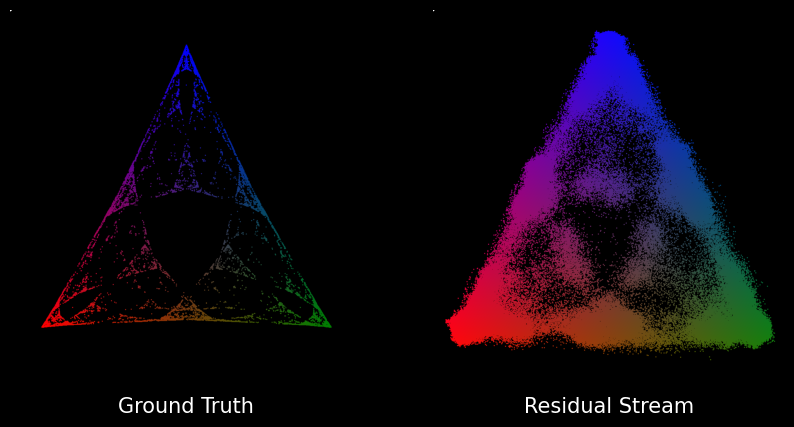

In [17]:
fig = plot_model_activations(model, SEQ_LEN, BATCH_SIZE_PLOT=4000, n_jobs = -1)

## Residual stream geometry during training

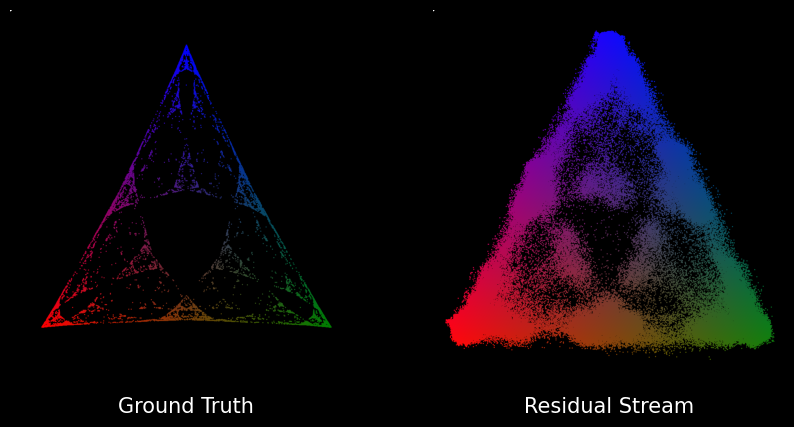

In [20]:
fig = plot_model_activations(model, SEQ_LEN, BATCH_SIZE_PLOT=4000);
plt.savefig(f"plots/trained_fractals_L{model.cfg.n_layers}_H{model.cfg.n_heads}.png", dpi=300, bbox_inches="tight")

Saved GIF to plots/training_progress_L3_H4_S100.gif


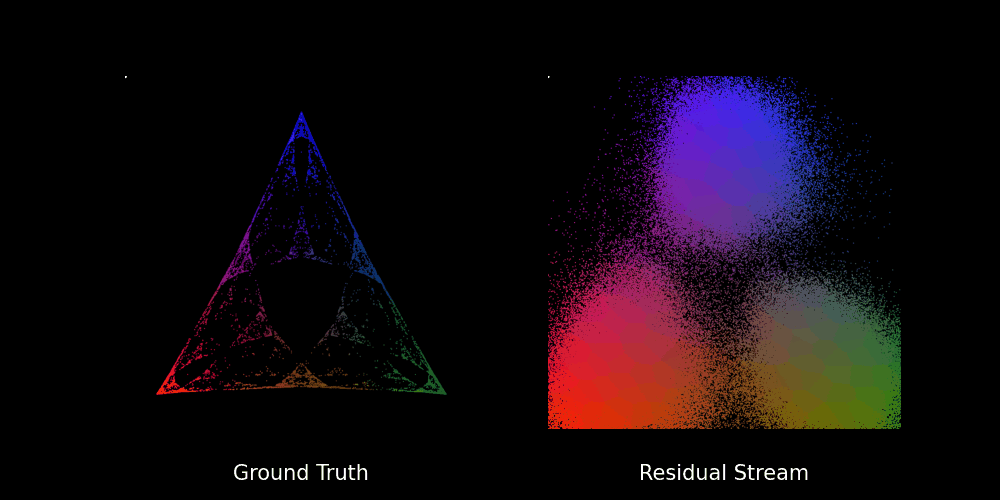

In [19]:
# Convert all figures to images.
images = [fig_to_array(fig) for fig in figs]

# Write the images as an animated GIF.
gif_filename = f"plots/training_progress_L{model.cfg.n_layers}_H{model.cfg.n_heads}_S{SEQ_LEN}.gif"
imageio.mimwrite(gif_filename, images, fps=5)  # Adjust fps as needed

print(f"Saved GIF to {gif_filename}")

# Display the GIF in the notebook
display(IPython.display.Image(filename=f"{gif_filename}"))